In [1]:
#@title MIT License
#
# Copyright (c) 2020 Balázs Pintér
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Training a simple neural network

In [5]:
import numpy as np
import scipy
import scipy.sparse as sps
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import tensorflow as tf
from nltk.corpus import movie_reviews

In [6]:
num_of_features = 5000

## Loading the dataset

Dataset URL: https://www.kaggle.com/neiljs/all-shark-tank-us-pitches-deals

In [8]:
df = pd.read_csv('Sharktankpitchesdeals.csv') # Make sure to adjust the path!
df.head()

,Season_Epi_code,Pitched_Business_Identifier,Pitched_Business_Desc,Deal_Status,Deal_Shark
0,826,Bridal Buddy,a functional slip worn under a wedding gown th...,1,KOL+LG
1,826,Laid Brand,hair-care products made with pheromones . Laid...,0,NaN
2,826,Rocketbook,a notebook that can scan contents to cloud ser...,0,NaN
3,826,Wine & Design,painting classes with wine served . Wine & Des...,1,KOL
4,824,Peoples Design,a mixing bowl with a built-in scoop . Peoples ...,1,LG


In [9]:
for pitch in df.loc[:3, 'Pitched_Business_Desc']:
    print(pitch)
    print('-----------------------')

a functional slip worn under a wedding gown that allows the wearer to use the restroom on their own . Bridal Buddy is a lightweight slip worn under the gown that lets brides go to the bathroom while wearing it. When nature calls, the bride can bag up her bustle to safely relieve herself without making a mess.
-----------------------
hair-care products made with pheromones . Laid brand is a Â pheromone-enriched hair care product thatÂ enhances color, in addition to protecting and hydrating hair.Â The pheromones help girls â€œexude confidenceâ€ wherever she goes.
-----------------------
a notebook that can scan contents to cloud services via an app and can be erased by being microwaved . Rocketbook is an intelligent reusable notebook that allows users to write with a traditional pen and notebook. The notebook is erasable and reusable by allowing users to send notes to the cloud. Simply use a smartphone to send writings to the cloud and a microwave oven to erase for future use.
---------

In [10]:
corpus = [pitch for pitch in df.loc[:, 'Pitched_Business_Desc']]
corpus[:3]

['a functional slip worn under a wedding gown that allows the wearer to use the restroom on their own . Bridal Buddy is a lightweight slip worn under the gown that lets brides go to the bathroom while wearing it. When nature calls, the bride can bag up her bustle to safely relieve herself without making a mess.',
 'hair-care products made with pheromones . Laid brand is a Â\xa0pheromone-enriched hair care product thatÂ\xa0enhances color, in addition to protecting and hydrating hair.Â\xa0The pheromones help girls â€œexude confidenceâ€\x9d wherever she goes.',
 'a notebook that can scan contents to cloud services via an app and can be erased by being microwaved . Rocketbook is an intelligent reusable notebook that allows users to write with a traditional pen and notebook. The notebook is erasable and reusable by allowing users to send notes to the cloud. Simply use a smartphone to send writings to the cloud and a microwave oven to erase for future use.']

In [11]:
targets = [deal for deal in df.loc[:, 'Deal_Status']]
targets[:5]

[1, 0, 0, 1, 1]

In [12]:
set(targets)

{0, 1}

### Bag of words representation

In [13]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=20)
bows = count_vectorizer.fit_transform(corpus)
pd.DataFrame(bows.toarray(), columns=count_vectorizer.get_feature_names_out()).head()

,allows,app,children,clothing,company,designed,device,free,high,itâ,kids,like,line,natural,offers,perfect,products,service,use,way
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=num_of_features)
bows = count_vectorizer.fit_transform(corpus)
print("We have {} pitches.".format(bows.shape[0]))

We have 706 pitches.


### Producing training and test data

In [15]:
# the problem: we have sparse arrays, but neural network need dense arrays!
# the solution will be word embeddings, here we just convert to dense arrays
bows = bows.toarray().astype(np.float32)
targets = np.array(targets, dtype=np.float32)

In [16]:
num_of_train = 600
X_train, y_train = bows[:num_of_train], targets[:num_of_train]
X_test, y_test = bows[num_of_train:], targets[num_of_train:]

In [17]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
X_train[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [19]:
# the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

### The weights of a single neuron are in a vector

In [20]:
w = np.array([1, 2, 3])
x = np.array([1, 2, 3])
w @ x

np.int64(14)

### The weights of a layer of neurons are in a matrix

In [21]:
w = np.array([[1, 2, 3], [1, 1, 1], [2, 2, 2]])
x = np.array([1, 2, 3])
w @ x

array([14,  6, 12])

In [22]:
w

array([[1, 2, 3],
       [1, 1, 1],
       [2, 2, 2]])

#### bias

In [23]:
b = [3, 4, 5]
w @ x + b

array([17, 10, 17])

In [24]:
w @ np.array([0, 0, 0])

array([0, 0, 0])

In [25]:
w @ np.array([0, 0, 0]) + b

array([3, 4, 5])

#### activation function

In [26]:
sigmoid(w @ x + b)

array([0.99999996, 0.9999546 , 0.99999996])

In [27]:
sigmoid(w @ sigmoid(w @ x + b) + b)

array([0.99987659, 0.99908891, 0.9999833 ])

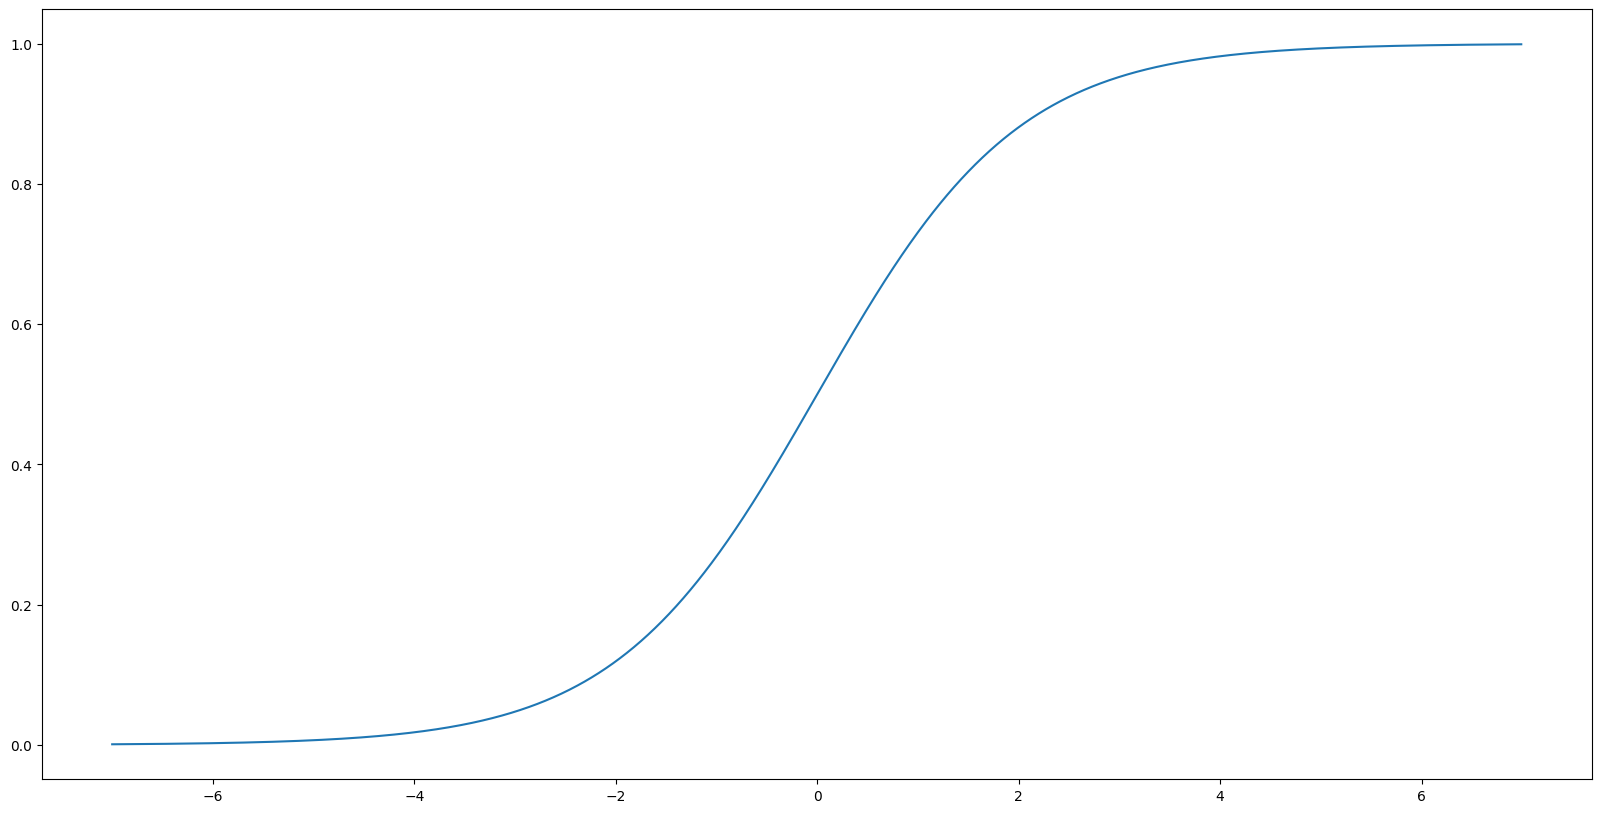

In [28]:
x = np.arange(-7, 7, 0.01)
fix, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(x, sigmoid(x))

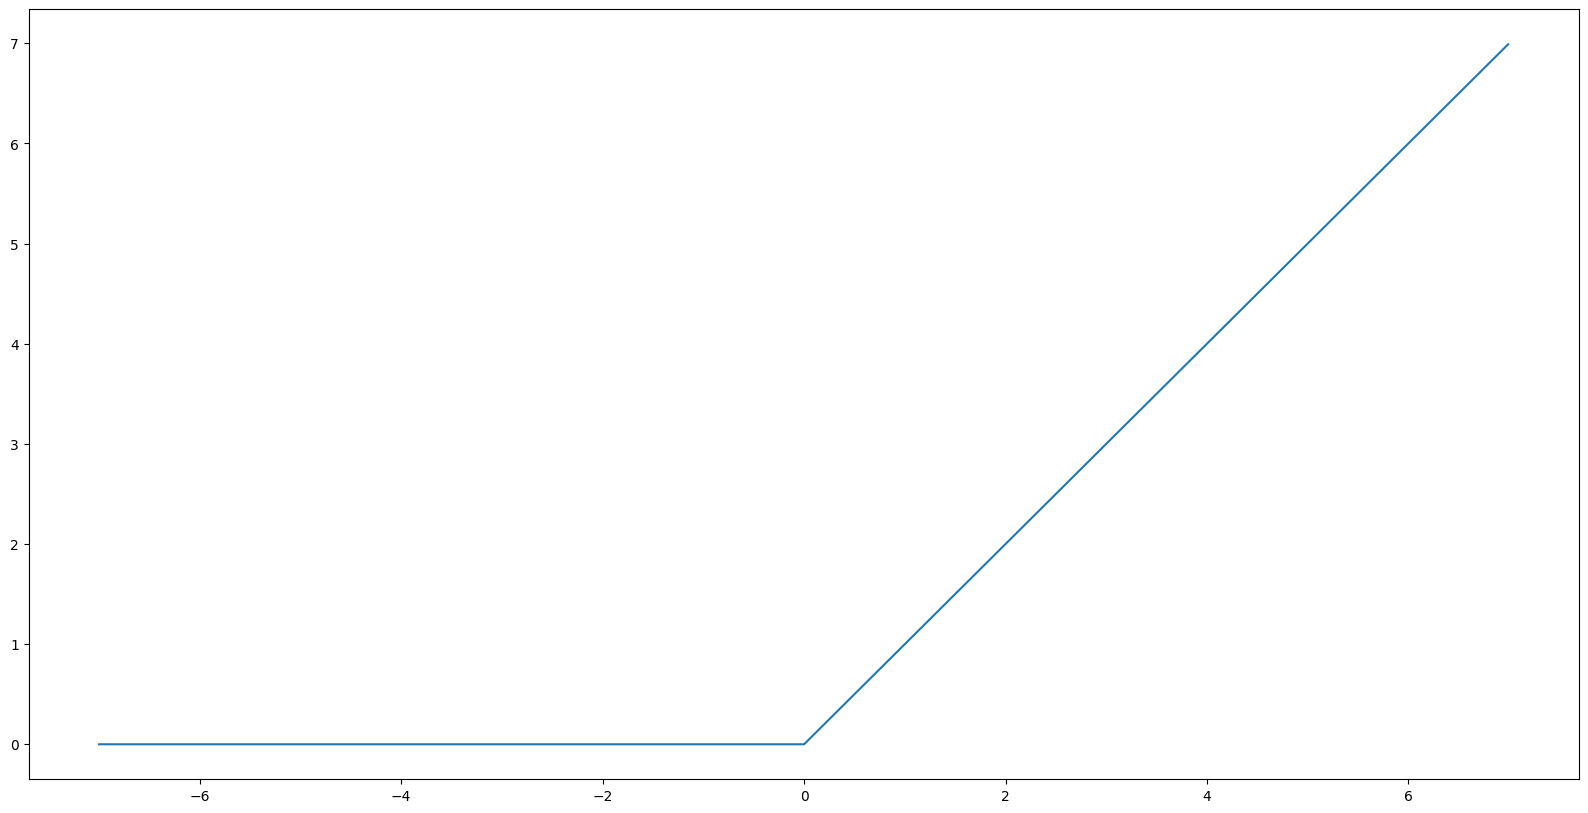

In [29]:
# the relu activation function
x = np.arange(-7, 7, 0.01)
fix, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(x, [max(xe, 0) for xe in x])

### Optimization algorithm: some kind of gradient descent

### Loss function: binary crossentropy

If $y_i$ are the true labels, and $\hat{y}_i$ are the predictions of the network:

$- \frac{1}{N} \sum_{i=1}^{N} y_i * log(\hat{y}_i) + (1-y_i)*log(1-\hat{y}_i)$

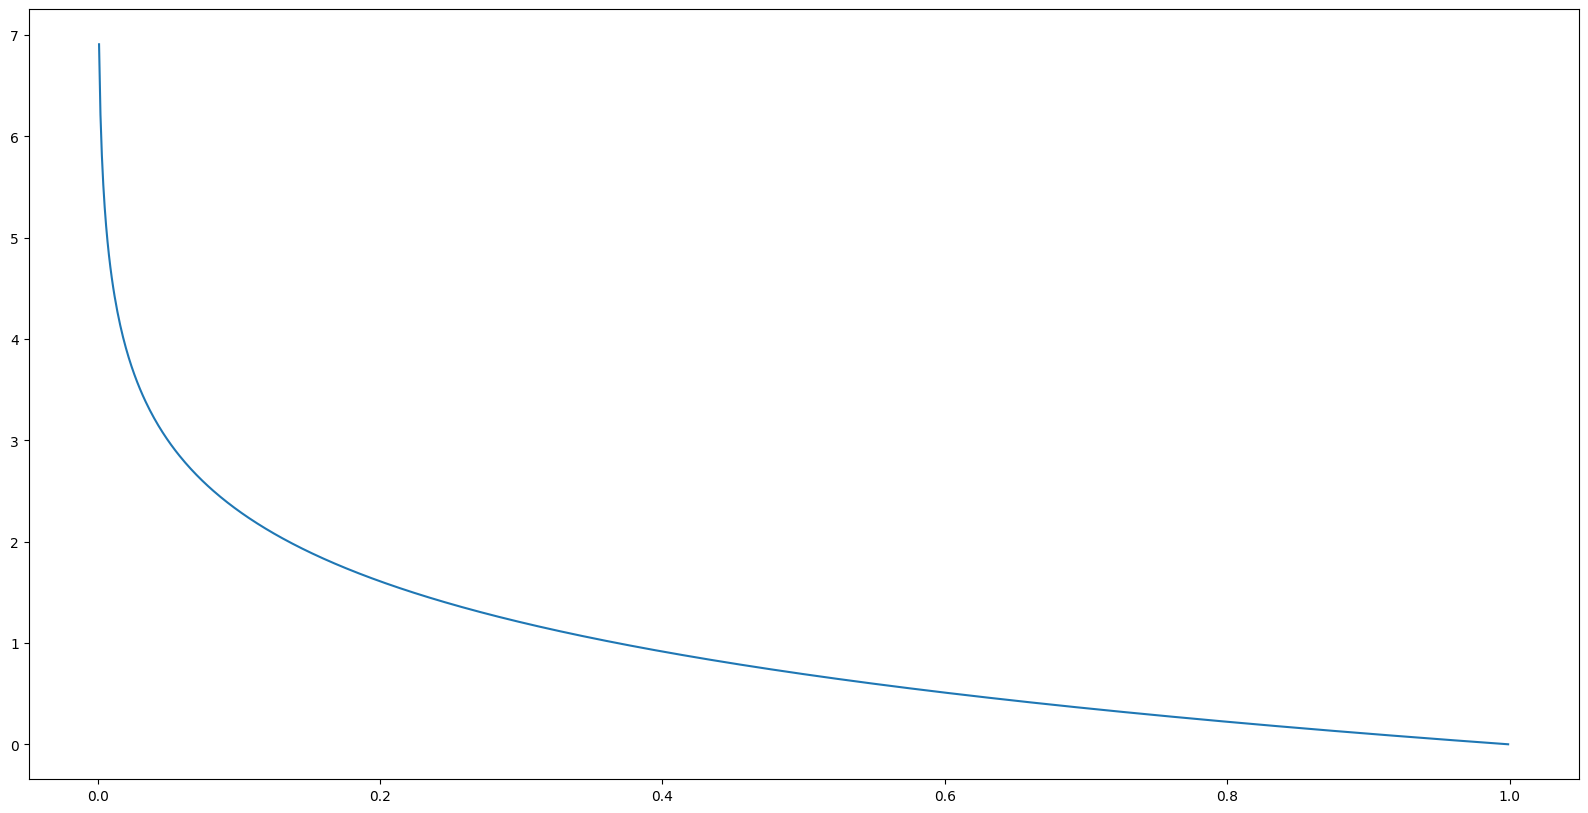

In [30]:
x = np.arange(0.001, 1.0, 0.001)
fix, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(x, -np.log(x))

## Computational graph

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

In [32]:
# we compile our neural network model
# we also have to choose an optimizer and a loss function
# for a binary classification task usually binary cross-entropy is fine
# we use accuracy as the metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-11-19 13:42:41.320856: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [33]:
# training or in other words, fitting the model to the data
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5105 - loss: 0.69219
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6912 - loss: 0.6519
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7286 - loss: 0.6152
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8048 - loss: 0.5561
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.4875
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9393 - loss: 0.3941
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.3072
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9776 - loss: 0.2276
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9937 - loss: 0.1651
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.1220


In [34]:
# looks very good, but
# let's evaluate on the test set
model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4629 - loss: 0.9205  


[0.9210326075553894, 0.49056604504585266]

### Overfitting

## Let's try another dataset!
Movie reviews - positive or negative

In [35]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [36]:
print(movie_reviews.raw('neg/cv000_29416.txt'))

plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have no id

In [37]:
corpus, targets = zip(*[(movie_reviews.raw(fileid), category)
                         for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)])

In [38]:
targets[:10]

('neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg', 'neg')

In [39]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=num_of_features)
bows = count_vectorizer.fit_transform(corpus)
print("We have {} documents.".format(bows.shape[0]))

We have 2000 documents.


In [40]:
set(targets)

{'neg', 'pos'}

In [41]:
# convert targets to numbers
targets = np.array([0 if target == 'neg' else 1 for target in targets])
targets[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [42]:
# we need to shuffle
perm = np.random.permutation(len(targets))
bows = bows[perm]
targets = targets[perm].astype(np.float32)

In [43]:
bows = bows.toarray().astype(np.float32)

In [44]:
num_of_train = 1800
X_train, y_train = bows[:num_of_train], targets[:num_of_train]
X_test, y_test = bows[num_of_train:], targets[num_of_train:]

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6033 - loss: 0.6589 - val_accuracy: 0.8778 - val_loss: 0.4285
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9129 - loss: 0.2961 - val_accuracy: 0.8944 - val_loss: 0.2908
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9859 - loss: 0.1019 - val_accuracy: 0.8778 - val_loss: 0.3161
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9990 - loss: 0.0326 - val_accuracy: 0.8889 - val_loss: 0.3285
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0106 - val_accuracy: 0.9000 - val_loss: 0.3487
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.9000 - val_loss: 0.3786
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9000 - val_loss: 0.4029
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8944 - val_loss: 0.4277
Epo

In [50]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.6526


[0.6251416206359863, 0.875]